# Import Utilities

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
os.chdir('/content/gdrive/My Drive/')

In [0]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook

In [0]:
viram = pd.read_csv("comment_vibharam-hospital.csv")
viram = viram.reset_index()
viram = viram.rename(columns={"index": "cid"})

#Comment Translation

In [5]:
!pip install googletrans
!pip install tqdm --upgrade
!pip install twython

Requirement already up-to-date: tqdm in /usr/local/lib/python3.6/dist-packages (4.45.0)


In [0]:
from googletrans import Translator
from tqdm import tqdm

In [0]:
def th2en(comment):
  return Translator().translate(comment, src="th", dest="en").text

In [8]:
tqdm.pandas()

viram["en"] = viram.progress_apply(lambda x: th2en(x["comment"]), axis=1)

100%|██████████| 183/183 [00:26<00:00,  6.81it/s]


# Sentence Tokenize and Sentence-level sentiment

In [9]:
import nltk
from nltk import sent_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download("vader_lexicon")
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [0]:
sentences = []
cids = []
for cid in viram["cid"]:
    s = sent_tokenize(viram.loc[cid, "en"])
    sentences = sentences + s
    cids = cids + [cid] * len(s)

In [0]:
def predict_sentiment(sentence):
  sa = SentimentIntensityAnalyzer()
  sentiment_distribution = sa.polarity_scores(sentence)
  score = sentiment_distribution.get("compound")
  
  if score >= 0.05:
    return "positive"
  elif score <= -0.05:
    return "negative"
  else:
    return "neutral"

In [12]:
sentiments = []
for sentence in tqdm_notebook(sentences, total=len(sentences)):
    sentiments.append(predict_sentiment(sentence))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


# Parsing

In [13]:
nltk.download('averaged_perceptron_tagger')
from nltk import word_tokenize, pos_tag, RegexpParser

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [0]:
grammar = """NP: {<NN|NNS>+}
                 {<NN|NNS>+<CC><NN|NNS>+}"""
chunker = RegexpParser(grammar)
parse_trees = []
for sentence in sentences:
    parse_trees.append(chunker.parse(pos_tag(word_tokenize(sentence))))

In [15]:
parse_trees

[Tree('S', [('Took', 'VB'), ('my', 'PRP$'), Tree('NP', [('car', 'NN'), ('crash', 'NN'), ('None', 'NN')]), ('of', 'IN'), ('the', 'DT'), Tree('NP', [('parties', 'NNS')]), ('have', 'VBP'), ('a', 'DT'), Tree('NP', [('car', 'NN'), ('insurance', 'NN')]), ('with', 'IN'), ('the', 'DT'), ('Social', 'NNP'), ('Security', 'NNP'), ('Act', 'NNP'), ('itself', 'PRP'), ('.', '.')]),
 Tree('S', [('Fortunately', 'RB'), (',', ','), ('the', 'DT'), Tree('NP', [('surgeon', 'NN'), ('emergency', 'NN')]), ('a', 'DT'), Tree('NP', [('fast', 'NN')]), (',', ','), ('do', 'VBP'), ('not', 'RB'), ('be', 'VB'), ('tortured', 'VBN'), ('again', 'RB'), ('fencing', 'VBG'), ('also', 'RB'), ('polite', 'VBP'), (',', ','), ('even', 'RB'), ('in', 'IN'), ('the', 'DT'), Tree('NP', [('name', 'NN')]), (',', ','), ('Social', 'NNP'), ('Security', 'NNP'), ('or', 'CC'), ('the', 'DT'), Tree('NP', [('year', 'NN')]), ('through', 'IN'), Tree('NP', [('bird', 'NN')]), ('Act', 'NNP'), ('of', 'IN'), ('the', 'DT'), Tree('NP', [('hospital', 'NN')]

# Extract Noun Phrase

In [0]:
def extract_np(parsed_tree):
    nps = []
    for subtree in parsed_tree.subtrees():
        if subtree.label() == 'NP':
            t = subtree
            t = " ".join(word for word, tag in t.leaves())
            nps.append(t)
    return nps

In [0]:
nps = []
for parse_tree in parse_trees:
    nps.append(extract_np(parse_tree))

In [18]:
nps

[['car crash None', 'parties', 'car insurance'],
 ['surgeon emergency', 'fast', 'name', 'year', 'bird', 'hospital', 'cost'],
 ['hospital', 'cost', 'cash', 'costs'],
 ['assistant nursing care', 'time'],
 ['Appointments', 'neat'],
 ['services', 'hospital'],
 ['care', 'doctor', 'appointment process'],
 [],
 ['doctors', 'care', 'doctor', 'lot'],
 ['delivery room',
  'child',
  'brothers',
  'nurseries kind',
  'care',
  'mother',
  'child performance',
  'services'],
 [],
 ['service', 'doctor', 'kind', 'cute nurse', 'parking'],
 ['equipment', 'bathrooms', 'corridors', 'food'],
 ['hospital'],
 ['specialist'],
 ['Nursing', 'personnel', 'others', 'cute'],
 ['Injection'],
 ['nurses', 'patients', 'doctor', 'effort', 'patient', 'doctor'],
 ['patient'],
 ['Patients', 'hospital', 'patient', 'enclosure', 'hospital'],
 ['nursing care', 'treatment'],
 ['love', 'parking'],
 ['equipment', 'bathrooms', 'corridors', 'food'],
 ['hospital'],
 ['specialist'],
 ['Nursing', 'personnel', 'others', 'cute'],
 ['

# Put information into DataFrame

In [0]:
df = pd.DataFrame({"cids": cids, 
                   "sentences": sentences, 
                   "sentiments": sentiments, 
                   "NP": nps})

In [20]:
df.head(10)

,cids,sentences,sentiments,NP
0,0,Took my car crash None of the parties have a c...,negative,"[car crash None, parties, car insurance]"
1,0,"Fortunately, the surgeon emergency a fast, do ...",positive,"[surgeon emergency, fast, name, year, bird, ho..."
2,0,Min hospital had to calculate the cost to make...,neutral,"[hospital, cost, cash, costs]"
3,0,And assistant nursing care was out of time.,positive,"[assistant nursing care, time]"
4,0,"Appointments made a neat, clean, clear",positive,"[Appointments, neat]"
5,1,Using the services of a hospital Vibharam sinc...,neutral,"[services, hospital]"
6,1,Maternity and child care or medical doctor's a...,positive,"[care, doctor, appointment process]"
7,1,The Vibharam it.,neutral,[]
8,1,Many doctors are able to take care of a good d...,positive,"[doctors, care, doctor, lot]"
9,1,PACU delivery room very good especially for a ...,positive,"[delivery room, child, brothers, nurseries kin..."


In [0]:
df['sentences'] = df['sentences'].str.replace("[^a-zA-Z#]", " ")

In [0]:
df['sentiments'] = df['sentiments'].str.replace("[^a-zA-Z#]", " ")

# Split dataframe into positive and negative sentiment

In [0]:
pos = df[df["sentiments"] == "positive"].reset_index(drop=True)
pos_words = sum(pos["NP"].tolist(), [])
pos_words = [word.lower() for word in pos_words]
poshist = pd.DataFrame({"words": pos_words})
poshist = poshist.groupby("words").size().reset_index(name="#pos")

In [0]:
neg = df[df["sentiments"] == "negative"].reset_index(drop=True)
neg_words = sum(neg["NP"].tolist(), [])
neg_words = [word.lower() for word in neg_words]
neghist = pd.DataFrame({"words": neg_words})
neghist = neghist.groupby("words").size().reset_index(name="#neg")

# Word Cloud Representation

In [0]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [0]:
def vizwordcloud(df):
    tuples = [tuple(x) for x in df.values]
    wordcloud = WordCloud().generate_from_frequencies(dict(tuples))
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

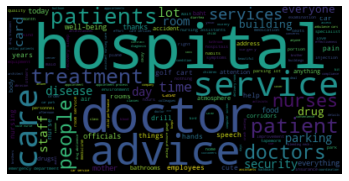

In [27]:
vizwordcloud(poshist)

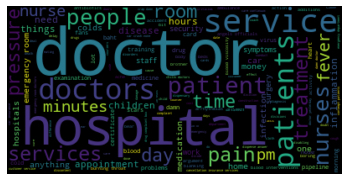

In [28]:
vizwordcloud(neghist)

In [0]:
def plural2singular(word):
  if word == "doctors":
    return "doctor"
  elif word == "nurses":
    return "nurse"
  elif word == "clinics":
    return "clinic"
  elif word == "hospitals":
    return "hospital"
  elif word == "services":
    return "service"
  elif word == "staffs":
    return "staff"
  elif word == "treatments":
    return "treatment"
  elif word == "students":
    return "student"
  else:
    return word

In [0]:
pos_words = [plural2singular(word) for word in pos_words]
poshist = pd.DataFrame({"words": pos_words})
poshist = poshist.groupby("words").size().reset_index(name="#pos")

neg_words = [plural2singular(word) for word in neg_words]
neghist = pd.DataFrame({"words": neg_words})
neghist = neghist.groupby("words").size().reset_index(name="#neg")

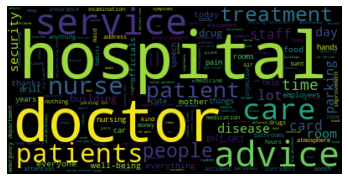

In [31]:
vizwordcloud(poshist)

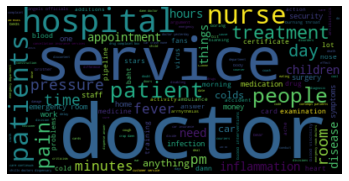

In [32]:
vizwordcloud(neghist)

# Plot Radar Chart

In [0]:
def groups(word):
    if word in ("doctor", "nurse", "student"):
        return "staff"
    elif word in ("hospital", "clinic", "equipment", "place"):
        return "infrastructure"
    elif word in ("service", "care", "treatment", "surgery", "disease", "medical care"):
        return "service"
    elif word in ("queue", "appointment"):
        return "process"
    elif word in ("price", "claim"):
        return "finance"
    else:
        return "others"

In [0]:
poshist["category"] = poshist["words"].apply(lambda x: groups(x))
poscount = poshist.groupby("category").size().reset_index(name="#")
poscount = poscount[poscount["category"] != "others"].reset_index(drop=True)

In [0]:
neghist["category"] = neghist["words"].apply(lambda x: groups(x))
negcount = neghist.groupby("category").size().reset_index(name="#")
negcount = negcount[negcount["category"] != "others"].reset_index(drop=True)

In [36]:
poscount

,category,#
0,infrastructure,3
1,process,1
2,service,5
3,staff,2


In [37]:
negcount

,category,#
0,finance,1
1,infrastructure,1
2,process,2
3,service,5
4,staff,2


In [0]:
import plotly.express as px
from plotly.offline import download_plotlyjs, init_notebook_mode,  plot

In [39]:
fig = px.line_polar(poscount, r="#", theta="category", line_close=True)
plot(fig)

'temp-plot.html'

In [40]:
fig_2 = px.line_polar(negcount, r="#", theta="category", line_close=True)
plot(fig_2)

'temp-plot.html'

# Extracting Features from cleaned comments

In [0]:
from wordcloud import ImageColorGenerator
from PIL import Image
import urllib
import requests

In [42]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

bow = bow_vectorizer.fit_transform(df['sentences'])

df_bow = pd.DataFrame(bow.todense())

df_bow

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
756,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
757,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [43]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=1000,stop_words='english')

tfidf_matrix=tfidf.fit_transform(df['sentences'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

df_tfidf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533
0,0.0,0.0,0.0,0.0,0.0,0.372803,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.366321,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.333506,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.452899,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.412328,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.648482,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.515883,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
755,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
756,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
757,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


# Splitting our dataset into Training and Validation Set

In [44]:
train_bow = bow[:31962]
train_bow.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 1, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

In [45]:
train_tfidf_matrix = tfidf_matrix[:31962]

train_tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.33350552, 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [46]:
from sklearn.preprocessing import LabelEncoder
number = LabelEncoder ()
df['sentiments'] = number.fit_transform(df['sentiments'].astype('str'))
df

,cids,sentences,sentiments,NP
0,0,Took my car crash None of the parties have a c...,0,"[car crash None, parties, car insurance]"
1,0,Fortunately the surgeon emergency a fast do ...,2,"[surgeon emergency, fast, name, year, bird, ho..."
2,0,Min hospital had to calculate the cost to make...,1,"[hospital, cost, cash, costs]"
3,0,And assistant nursing care was out of time,2,"[assistant nursing care, time]"
4,0,Appointments made a neat clean clear,2,"[Appointments, neat]"
...,...,...,...,...
754,181,Detailed service information Step well,2,[service information]
755,182,It is normal to see a doctor Regular doctor ab...,1,"[doctor, doctor, cholesterol]"
756,182,The doctor told me to take medicine on time b...,0,"[doctor, medicine, time]"
757,182,He came to the second doctor looked at it str...,0,"[doctor, fat, doctor, signal]"


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



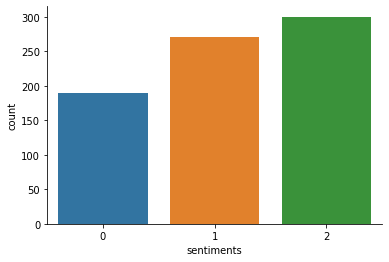

In [47]:
import seaborn as sns
sns.countplot(df['sentiments'])
sns.despine()

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
x_train_bow, x_valid_bow, y_train_bow, y_valid_bow = train_test_split(train_bow,df['sentiments'],test_size=0.3,random_state=0)

In [0]:
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(train_tfidf_matrix,df['sentiments'],test_size=0.3,random_state=0)

In [51]:
x_train_bow.shape

(531, 534)

In [52]:
x_valid_bow.shape

(228, 534)

In [53]:
y_train_bow.shape

(531,)

In [54]:
y_valid_bow.shape

(228,)

# Applying Machine Learning Models

In [0]:
from sklearn.metrics import f1_score

In [0]:
from sklearn.neural_network import MLPClassifier
class_NN = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu',solver='adam', max_iter=500)

In [57]:
class_NN.fit(x_train_bow,y_train_bow)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(8, 8, 8), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [58]:
prediction_bow = class_NN.predict_proba(x_valid_bow)

prediction_bow

array([[1.45460906e-02, 3.71632773e-02, 9.48290632e-01],
       [1.63238726e-05, 9.99983670e-01, 6.27946786e-09],
       [4.44396521e-02, 1.89095847e-01, 7.66464501e-01],
       [9.99995698e-01, 4.30171718e-06, 4.68699514e-10],
       [2.43485147e-01, 7.56496487e-01, 1.83664309e-05],
       [1.56138588e-04, 4.81968743e-05, 9.99795665e-01],
       [3.68319008e-03, 3.56918983e-03, 9.92747620e-01],
       [1.04272270e-04, 9.99688691e-01, 2.07037013e-04],
       [4.20226163e-05, 1.95892486e-05, 9.99938388e-01],
       [9.95449646e-01, 4.55034700e-03, 7.01492207e-09],
       [7.34485821e-01, 2.65436488e-01, 7.76908469e-05],
       [9.10496573e-06, 5.06424631e-01, 4.93566264e-01],
       [1.25163608e-02, 2.56851055e-02, 9.61798534e-01],
       [1.64114747e-04, 5.07100463e-05, 9.99785175e-01],
       [8.38581980e-07, 6.32947467e-06, 9.99992832e-01],
       [1.20529177e-05, 3.19281454e-06, 9.99984754e-01],
       [4.26826115e-03, 6.45784238e-03, 9.89273896e-01],
       [2.01801322e-01, 7.98191

In [59]:
prediction_int = prediction_bow[:,1]>=0.3


prediction_int = prediction_int.astype(np.int)
prediction_int


log_bow = f1_score(y_valid_bow, prediction_int,average='micro')

log_bow

0.41228070175438597

In [60]:
class_NN.fit(x_train_tfidf,y_train_tfidf)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(8, 8, 8), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=500,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [61]:
prediction_tfidf = class_NN.predict_proba(x_valid_tfidf)

prediction_tfidf

array([[1.11170556e-04, 4.85537129e-03, 9.95033458e-01],
       [4.46151809e-04, 9.99548512e-01, 5.33584950e-06],
       [8.27934496e-03, 6.52301031e-01, 3.39419625e-01],
       [9.98301399e-01, 1.32451893e-03, 3.74082150e-04],
       [4.96675544e-01, 5.01817765e-01, 1.50669108e-03],
       [1.11461629e-03, 1.63096515e-02, 9.82575732e-01],
       [2.24007037e-05, 1.74675528e-03, 9.98230844e-01],
       [4.60132622e-05, 9.99900452e-01, 5.35344437e-05],
       [2.94585661e-05, 2.00906104e-03, 9.97961480e-01],
       [7.93046479e-01, 2.06179474e-01, 7.74046280e-04],
       [1.07906739e-02, 5.63902875e-02, 9.32819039e-01],
       [1.01335825e-05, 6.97662413e-01, 3.02327453e-01],
       [6.42474679e-02, 1.54917391e-01, 7.80835141e-01],
       [3.55523715e-06, 6.81926801e-04, 9.99314518e-01],
       [1.72796360e-06, 1.40844846e-03, 9.98589824e-01],
       [1.71892137e-05, 1.52573288e-03, 9.98457078e-01],
       [2.08854727e-04, 5.08656793e-03, 9.94704577e-01],
       [1.44926824e-03, 9.97930

In [62]:
prediction_int_tfidf = prediction_tfidf[:,1]>=0.3

prediction_int_tfidf = prediction_int.astype(np.int)
prediction_int_tfidf


log_tfidf = f1_score(y_valid_tfidf, prediction_int_tfidf,average='micro')

log_tfidf

0.41228070175438597

In [63]:
from xgboost import XGBClassifier
model_bow = XGBClassifier(random_state=0,learning_rate=0.9)
model_bow.fit(x_train_bow, y_train_bow)
xgb = model_bow.predict_proba(x_valid_bow)

xgb

array([[9.39854532e-02, 4.70282882e-01, 4.35731679e-01],
       [1.99546851e-02, 9.80001032e-01, 4.42390483e-05],
       [1.38207838e-01, 6.91562116e-01, 1.70230001e-01],
       [4.86813456e-01, 4.11816627e-01, 1.01369843e-01],
       [5.08223027e-02, 8.13120008e-01, 1.36057645e-01],
       [6.22877032e-02, 6.64175139e-04, 9.37048197e-01],
       [5.45060754e-01, 2.20158026e-01, 2.34781221e-01],
       [6.58283234e-02, 8.53091240e-01, 8.10804889e-02],
       [4.24181148e-02, 5.98416701e-02, 8.97740245e-01],
       [9.46440816e-01, 5.22809848e-02, 1.27818505e-03],
       [6.48548603e-01, 3.15425187e-01, 3.60261984e-02],
       [3.46170180e-02, 1.06128693e-01, 8.59254360e-01],
       [4.36715037e-02, 3.86837423e-02, 9.17644739e-01],
       [2.13845279e-02, 8.64577573e-03, 9.69969630e-01],
       [5.57867944e-01, 4.06589836e-01, 3.55421938e-02],
       [7.43079543e-01, 6.02673404e-02, 1.96653143e-01],
       [6.12448007e-02, 1.81489028e-02, 9.20606315e-01],
       [8.67449760e-01, 6.65056

In [64]:
xgb = xgb[:,1] >= 0.3


xgb_int=xgb.astype(np.int)


xgb_bow=f1_score(y_valid_bow,xgb_int,average='micro')

xgb_bow

0.4298245614035088

In [65]:
model_tfidf = XGBClassifier(random_state=2,learning_rate=0.7)
model_tfidf.fit(x_train_tfidf, y_train_tfidf)
xgb_tfidf=model_tfidf.predict_proba(x_valid_tfidf)

xgb_tfidf

array([[1.70337826e-01, 6.61240280e-01, 1.68421879e-01],
       [2.04657037e-02, 9.76663768e-01, 2.87049613e-03],
       [1.70337826e-01, 6.61240280e-01, 1.68421879e-01],
       [2.56865531e-01, 5.92277765e-01, 1.50856718e-01],
       [2.27966271e-02, 9.23393428e-01, 5.38099222e-02],
       [1.39974067e-02, 2.68871430e-04, 9.85733747e-01],
       [3.93147290e-01, 2.24820018e-01, 3.82032722e-01],
       [8.59543756e-02, 8.29057992e-01, 8.49875584e-02],
       [5.37469015e-02, 4.62481752e-02, 9.00004983e-01],
       [8.44562531e-01, 1.43619001e-01, 1.18185235e-02],
       [5.35912454e-01, 3.42448890e-01, 1.21638641e-01],
       [3.03506199e-02, 1.74053330e-02, 9.52244043e-01],
       [2.53938772e-02, 4.95203249e-02, 9.25085843e-01],
       [1.37786176e-02, 4.86082584e-03, 9.81360555e-01],
       [5.69771111e-01, 3.88378561e-01, 4.18503024e-02],
       [7.68621266e-01, 1.11603133e-01, 1.19775616e-01],
       [5.48635125e-02, 5.13973720e-02, 8.93739164e-01],
       [9.52998459e-01, 1.31843

In [66]:
xgb_tfidf=xgb_tfidf[:,1]>=0.3


xgb_int_tfidf=xgb_tfidf.astype(np.int)

score=f1_score(y_valid_tfidf,xgb_int_tfidf,average='micro')

score

0.4473684210526316

In [67]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(criterion='entropy', random_state=0)
dct.fit(x_train_bow,y_train_bow)
dct_bow = dct.predict_proba(x_valid_bow)

dct_bow

array([[0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.125     , 0.83333333, 0.04166667],
       [0.125     , 0.83333333, 0.04166667],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.125     , 0.83333333, 0.04166667],
       [0.125     , 0.83333333, 0.04166667],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.

In [68]:
dct_bow=dct_bow[:,1]>=0.3


dct_int_bow=dct_bow.astype(np.int)


dct_score_bow=f1_score(y_valid_bow,dct_int_bow,average='micro')

dct_score_bow

0.4605263157894737

In [69]:
dct.fit(x_train_tfidf,y_train_tfidf)
dct_tfidf = dct.predict_proba(x_valid_tfidf)

dct_tfidf

array([[0.125     , 0.83333333, 0.04166667],
       [0.        , 1.        , 0.        ],
       [0.125     , 0.83333333, 0.04166667],
       [0.125     , 0.83333333, 0.04166667],
       [0.125     , 0.83333333, 0.04166667],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.        , 0.        , 1.        ],
       [1.        , 0.        , 0.        ],
       [0.125     , 0.83333333, 0.04166667],
       [0.125     , 0.83333333, 0.04166667],
       [1.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        ],
       [0.

In [70]:
dct_tfidf=dct_tfidf[:,1]>=0.3

dct_int_tfidf=dct_tfidf.astype(np.int)


dct_score_tfidf=f1_score(y_valid_tfidf,dct_int_tfidf,average='micro')

dct_score_tfidf

0.4166666666666667

# Model Comparison

In [71]:
Algo_1 = ['NeuralNetwork(Bag-of-Words)','XGBoost(Bag-of-Words)','DecisionTree(Bag-of-Words)']

score_1 = [log_bow,xgb_bow,dct_score_bow]

compare_1 = pd.DataFrame({'Model':Algo_1,'F1_Score':score_1},index=[i for i in range(1,4)])

compare_1.T

,1,2,3
Model,NeuralNetwork(Bag-of-Words),XGBoost(Bag-of-Words),DecisionTree(Bag-of-Words)
F1_Score,0.412281,0.429825,0.460526


In [72]:
Algo_2 = ['NeuralNetwork(TF-IDF)','XGBoost(TF-IDF)','DecisionTree(TF-IDF)']

score_2 = [log_tfidf,score,dct_score_tfidf]

compare_2 = pd.DataFrame({'Model':Algo_2,'F1_Score':score_2},index=[i for i in range(1,4)])

compare_2.T

,1,2,3
Model,NeuralNetwork(TF-IDF),XGBoost(TF-IDF),DecisionTree(TF-IDF)
F1_Score,0.412281,0.447368,0.416667


# Evaluating the model

In [0]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [74]:
print (y_valid_bow)

747    0
583    2
575    2
40     0
243    0
      ..
34     2
708    0
462    2
755    1
358    1
Name: sentiments, Length: 228, dtype: int64


In [75]:
print (y_valid_tfidf)

747    0
583    2
575    2
40     0
243    0
      ..
34     2
708    0
462    2
755    1
358    1
Name: sentiments, Length: 228, dtype: int64


# Comparison Graph

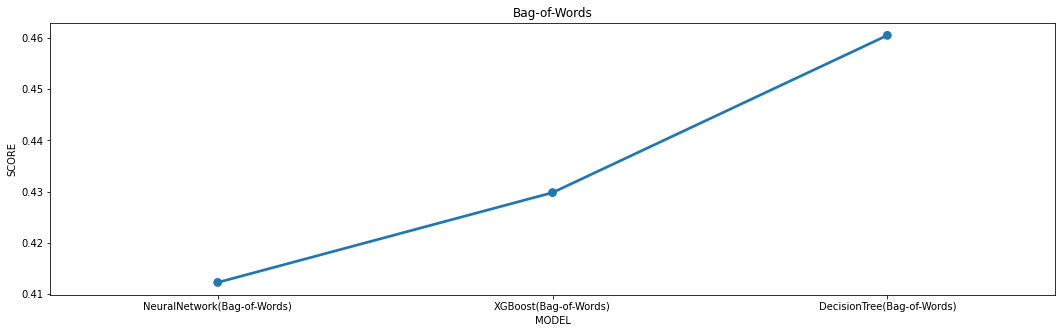

In [76]:
import seaborn as sns
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1_Score',data=compare_1)

plt.title('Bag-of-Words')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()

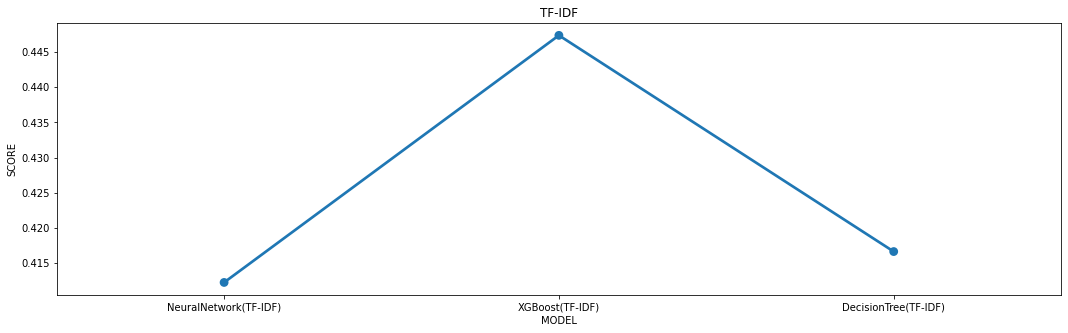

In [77]:
plt.figure(figsize=(18,5))

sns.pointplot(x='Model',y='F1_Score',data=compare_2)

plt.title('TF-IDF')
plt.xlabel('MODEL')
plt.ylabel('SCORE')

plt.show()